In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import sklearn.svm
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as rmse

# Lectura de Datos

In [34]:
train = pd.read_excel("train.xlsx")
val = pd.read_excel("val.xlsx")

# Agrupación de datos

Día

In [35]:
train_dia = train.groupby(['BARRIO','DIA','MES','ANIO']).sum().reset_index()
#data_dia = data_dia.to_frame()
train_dia.to_excel("train_dia.xlsx",index=False)
train_dia.head()

,BARRIO,DIA,MES,ANIO,ESPECIAL,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello
0,aguas frias,2,5,2018,0,0,0,1,0,0,0,0
1,aguas frias,2,8,2018,0,1,0,0,0,0,0,0
2,aguas frias,4,11,2018,0,0,1,1,0,0,0,0
3,aguas frias,10,8,2018,0,1,0,0,0,0,0,0
4,aguas frias,19,10,2018,0,0,0,0,1,0,0,0


In [70]:
val_dia = val.groupby(['BARRIO','DIA','MES','ANIO']).sum().reset_index()
#data_dia = data_dia.to_frame()
val_dia.to_excel("val_dia.xlsx",index=False)
val_dia.head()

,BARRIO,DIA,MES,ANIO,FECHAS_ESPECIALES,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello,BARRIO_ENCODER
0,aguas frias,1,2,2015,0,0,0,0,1,0,0,0,0
1,aguas frias,1,3,2014,0,0,0,1,0,0,0,0,0
2,aguas frias,1,9,2014,0,0,0,1,0,0,0,0,0
3,aguas frias,1,10,2015,0,0,0,1,0,0,0,0,0
4,aguas frias,2,5,2016,0,0,0,1,0,0,0,0,0


Mes

In [37]:
train_mes = train.groupby(['BARRIO','MES','ANIO']).sum().reset_index()
#data_dia = data_dia.to_frame()
train_mes.to_excel("train_mes.xlsx",index=False)
train_mes.head()

,BARRIO,MES,ANIO,ESPECIAL,DIA,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello
0,aguas frias,5,2018,0,22,0,0,2,0,0,0,0
1,aguas frias,8,2018,0,12,2,0,0,0,0,0,0
2,aguas frias,10,2018,0,19,0,0,0,1,0,0,0
3,aguas frias,11,2018,0,4,0,1,1,0,0,0,0
4,aldea pablo vi,1,2018,0,24,2,0,0,0,0,0,0


In [38]:
val_mes = val.groupby(['BARRIO','MES','ANIO']).sum().reset_index()
#data_dia = data_dia.to_frame()
val_mes.to_excel("val_mes.xlsx",index=False)
val_mes.head()

,BARRIO,MES,ANIO,FECHAS_ESPECIALES,DIA,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello
0,aguas frias,1,2014,0,30,0,0,1,0,0,0,0
1,aguas frias,1,2015,0,13,0,0,0,1,0,0,0
2,aguas frias,1,2016,0,26,0,0,2,1,0,0,0
3,aguas frias,2,2014,0,10,0,0,2,0,0,0,0
4,aguas frias,2,2015,0,28,0,0,1,1,0,0,0


# Predictor Mensual

# Lectura de datos

In [39]:
train = pd.read_excel("train_mes.xlsx")
val = pd.read_excel("val_mes.xlsx")

# LabelEncoder

LabelEnconder para el atributo barrio

In [40]:
le = LabelEncoder()
le.fit(train['BARRIO'].unique())
train['BARRIO_ENCODER']=le.transform(train['BARRIO'])
le = LabelEncoder()
le.fit(val['BARRIO'].unique())
val['BARRIO_ENCODER']=le.transform(val['BARRIO'])
train.head()
val.head()

,BARRIO,MES,ANIO,FECHAS_ESPECIALES,DIA,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello,BARRIO_ENCODER
0,aguas frias,1,2014,0,30,0,0,1,0,0,0,0,0
1,aguas frias,1,2015,0,13,0,0,0,1,0,0,0,0
2,aguas frias,1,2016,0,26,0,0,2,1,0,0,0,0
3,aguas frias,2,2014,0,10,0,0,2,0,0,0,0,0
4,aguas frias,2,2015,0,28,0,0,1,1,0,0,0,0


# X y y

In [41]:
X_train = train[['BARRIO_ENCODER','MES','ANIO']].values
y_train = train[['atropello','caida_ocupante','choque','choque_atropello','incendio','otro','volcamiento']].values

# Normalización

In [42]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
joblib.dump(min_max_scaler,"models/scaler_mes.pkl")

['models/scaler_mes.pkl']

# Entrenamiento del modelo

## Maquina de Soporte Vectorial

In [43]:
svm =  MultiOutputRegressor(sklearn.svm.SVR(),n_jobs=-1)
scores = cross_val_score(svm, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('R2 promedio:',np.mean(scores))
svm = svm.fit(X_train,y_train)
joblib.dump(svm, 'models/svm_mes.pkl')

R2 promedio: -21.698871039591676


['models/svm_mes.pkl']

In [44]:
y_pred = svm.predict(X_train)
rmse(y_train, y_pred)

22.004474842126605

## Bosque Aleatorio

In [45]:
bosque =  RandomForestRegressor()
scores = cross_val_score(bosque, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('R2 promedio:',np.mean(scores))
bosque = bosque.fit(X_train,y_train)
joblib.dump(bosque, 'models/bosque_mes.pkl',compress=9)

R2 promedio: -68.02957317332633


['models/bosque_mes.pkl']

In [46]:
y_pred = bosque.predict(X_train)
rmse(y_train, y_pred)

0.40879406760486964

### Ajuste de Parametros

In [50]:
clf =  RandomForestRegressor()
tuned_params = { 
            #"criterion": ['entropy','gini'],
            "max_features": [1,2,4,8,16],
            "n_estimators" :[512,1024],
            "min_samples_split" : [2,4,8,16,32],
            "bootstrap" : [False,True],
            "max_features": ['auto','sqrt'],
            "max_depth": [2,4,8,16,32,64,128]
            }


clf = GridSearchCV(clf, tuned_params,cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
clf.fit(X_train, y_train)
print("Mejores Parametros Encontrados")
print(clf.best_params_)

##
## Se entrena el clasificador
##
clf =  RandomForestRegressor(
    #criterion  = clf.best_params_['criterion'],
    max_features  = clf.best_params_['max_features'],
    n_estimators  = clf.best_params_['n_estimators'],
    min_samples_split  = clf.best_params_['min_samples_split'],
    bootstrap  = clf.best_params_['bootstrap'],
    max_depth  = clf.best_params_['max_depth'],
)


scores = cross_val_score(clf, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE CV entrenamiento promedio:',np.mean(scores))

### Se guarda el Modelo

bosque = clf.fit(X_train,y_train)
joblib.dump(bosque, 'models/bosque_tuning_mes.pkl',compress=9)



y_pred = bosque.predict(X_train)
print("RMSE entrenamiento:",rmse(y_train, y_pred))

Mejores Parametros Encontrados
{'bootstrap': True, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 1024}
RMSE CV entrenamiento promedio: -29.994550615700387
RMSE entrenamiento: 19.075179992198176


## Red Neuronal

parametros = {"hidden_layer_sizes":  [(18,),(20,),(25,),(50,),(100,),(18,2),(20,2),(25,2),(18,3),(20,3),(25,3),(18,4),(20,4),(25,4),(50,4),(100,4),(200,4),(18,5),(20,5),(25,5),(50,5),(100,5),(200,5)]}
red = sklearn.neural_network.MLPClassifier()
clf = GridSearchCV(red, parametros,cv=5,scoring='f1',n_jobs = -1)
clf.fit(X_train,y_train)
print("Mejores Parametros Encontrados")
print(clf.best_params_)

# Validacion

In [51]:
X_val = val[['BARRIO_ENCODER','MES','ANIO']].values
y_val = val[['atropello','caida_ocupante','choque','choque_atropello','incendio','otro','volcamiento']].values
X_val = min_max_scaler.transform(X_val)

## Bosque Aleatorio

Error de validación: 19.561701050272127


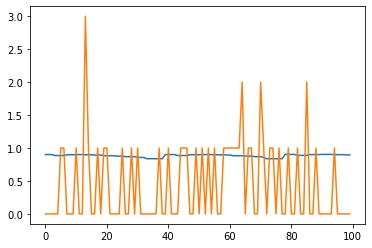

In [52]:
y_pred = bosque.predict(X_val)
print("Error de validación:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
plt.plot([i for i in range(100)],list(y_pred[0])[0:100])
plt.plot([i for i in range(100)],list(y_val[0])[0:100])

## SVM

RMSE  VALIDACION: 24.176499148614692


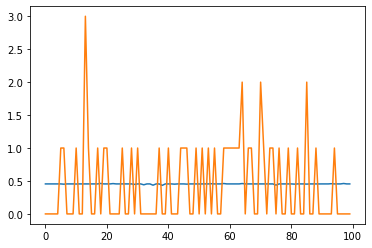

In [53]:
y_pred = svm.predict(X_val)
print("RMSE  VALIDACION:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
plt.plot([i for i in range(100)],list(y_pred[0])[0:100])
plt.plot([i for i in range(100)],list(y_val[0])[0:100])

# PREDICTOR DIARIO

## Lectura de Datos

In [73]:
train = pd.read_excel("train_dia.xlsx")
val = pd.read_excel("val_dia.xlsx")

## LabelEncoder

In [55]:
le = LabelEncoder()
le.fit(train['BARRIO'].unique())
train['BARRIO_ENCODER']=le.transform(train['BARRIO'])
le = LabelEncoder()
le.fit(val['BARRIO'].unique())
val['BARRIO_ENCODER']=le.transform(val['BARRIO'])
train.head()
val.head()

,BARRIO,DIA,MES,ANIO,FECHAS_ESPECIALES,atropello,caida_ocupante,choque,otro,volcamiento,incendio,choque_atropello,BARRIO_ENCODER
0,aguas frias,1,2,2015,0,0,0,0,1,0,0,0,0
1,aguas frias,1,3,2014,0,0,0,1,0,0,0,0,0
2,aguas frias,1,9,2014,0,0,0,1,0,0,0,0,0
3,aguas frias,1,10,2015,0,0,0,1,0,0,0,0,0
4,aguas frias,2,5,2016,0,0,0,1,0,0,0,0,0


## X y y

In [56]:
X_train = train[['BARRIO_ENCODER','MES','ANIO','ESPECIAL']].values
y_train = train[['atropello','caida_ocupante','choque','choque_atropello','incendio','otro','volcamiento']].values

## Normalización

In [57]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
joblib.dump(min_max_scaler,"models/scaler_dia.pkl")

['models/scaler_dia.pkl']

# Entrenamiento del Modelo

## SVM

In [58]:
svm =  MultiOutputRegressor(sklearn.svm.SVR(),n_jobs=-1)
scores = cross_val_score(svm, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE promedio:',np.mean(scores))
svm = svm.fit(X_train,y_train)
joblib.dump(svm, 'models/svm_dia.pkl')

RMSE promedio: -0.1899196985575175


['models/svm_dia.pkl']

In [59]:
y_pred = svm.predict(X_train)
rmse(y_train, y_pred)

0.18535355639963244

## Bosque Aleatorio

In [60]:
bosque =  RandomForestRegressor()
scores = cross_val_score(bosque, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE promedio:',np.mean(scores))
bosque = bosque.fit(X_train,y_train)
joblib.dump(bosque, 'models/bosque_dia.pkl',compress=9)

RMSE promedio: -0.26071056199028375


['models/bosque_dia.pkl']

In [61]:
y_pred = bosque.predict(X_train)
rmse(y_train, y_pred)

0.1340837302895612

### Ajuste de parametros

In [63]:
clf =  RandomForestRegressor()
tuned_params = { 
            #"criterion": ['entropy','gini'],
            "max_features": [1,2,4,8,16],
            "n_estimators" :[512,1024],
            "min_samples_split" : [2,4,8,16,32],
            "bootstrap" : [False,True],
            "max_features": ['auto','sqrt'],
            "max_depth": [2,4,8,16,32,64,128]
            }


clf = GridSearchCV(clf, tuned_params,cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
clf.fit(X_train,y_train)
print("Mejores Parametros Encontrados")
print(clf.best_params_)

##
## Se entrena el clasificador
##
clf =  RandomForestRegressor(
    #criterion  = clf.best_params_['criterion'],
    max_features  = clf.best_params_['max_features'],
    n_estimators  = clf.best_params_['n_estimators'],
    min_samples_split  = clf.best_params_['min_samples_split'],
    bootstrap  = clf.best_params_['bootstrap'],
    max_depth  = clf.best_params_['max_depth'],
)


scores = cross_val_score(clf, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE CV entrenamiento promedio:',np.mean(scores))

### Se guarda el Modelo

bosque = clf.fit(X_train,y_train)
joblib.dump(bosque, 'models/bosque_tuning_dia.pkl',compress=9)



y_pred = bosque.predict(X_train)
print("RMSE entrenamiento:",rmse(y_train, y_pred))

Mejores Parametros Encontrados
{'bootstrap': False, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 32, 'n_estimators': 1024}
RMSE CV entrenamiento promedio: -0.1912252928547103
RMSE entrenamiento: 0.17939592192340736


# Validación

In [74]:
X_val = val[['BARRIO_ENCODER','MES','ANIO','ESPECIAL']].values
y_val = val[['atropello','caida_ocupante','choque','choque_atropello','incendio','otro','volcamiento']].values
X_val = min_max_scaler.transform(X_val)

## Bosque Aleatorio

0.18833499211798996


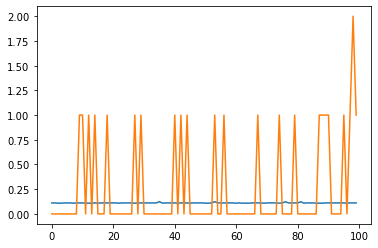

In [75]:
y_pred = bosque.predict(X_val)
print(rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
plt.plot([i for i in range(100)],list(y_pred[0])[0:100])
plt.plot([i for i in range(100)],list(y_val[0])[0:100])

## SVM

rmse: 0.19520876964902348


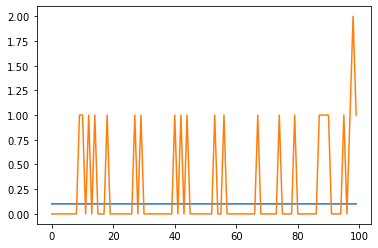

In [76]:
y_pred = svm.predict(X_val)
print("rmse:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
plt.plot([i for i in range(100)],list(y_pred[0])[0:100])
plt.plot([i for i in range(100)],list(y_val[0])[0:100])